In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

In [33]:
# Load the data
file_path = '../data/data2.csv'
data = pd.read_csv(file_path)

In [34]:
# Encode Categorical Variables: One-Hot Encoding
def one_hot_encode(data, categorical_features):
    data = pd.get_dummies(data, columns=categorical_features)
    return data

categorical_features = data.select_dtypes(include=['object']).columns.tolist()
data_one_hot_encoded = one_hot_encode(data, categorical_features)
print("One-Hot Encoded Data:")
print(data_one_hot_encoded.head())

One-Hot Encoded Data:
   TransactionId  BatchId  AccountId  SubscriptionId  CustomerId  CountryCode  \
0          76871    36123       3957             887        4406          256   
1          73770    15642       4841            3829        4406          256   
2          26203    53941       4229             222        4683          256   
3            380   102363        648            2185         988          256   
4          28195    38780       4841            3829         988          256   

   ProviderId  ProductId  ChannelId   Amount  ...  \
0           6         10          3   1000.0  ...   
1           4          6          2    -20.0  ...   
2           6          1          3    500.0  ...   
3           1         21          3  20000.0  ...   
4           4          6          2   -644.0  ...   

   TransactionStartTime_2019-02-13T09:50:20Z  \
0                                      False   
1                                      False   
2                           

In [35]:
# Encode Categorical Variables: Label Encoding
def label_encode(data, categorical_features):
    le = LabelEncoder()
    for feature in categorical_features:
        data[feature] = le.fit_transform(data[feature].astype(str))
    return data

data_label_encoded = label_encode(data, categorical_features)
print("Label Encoded Data:")
print(data_label_encoded.head())

Label Encoded Data:
   TransactionId  BatchId  AccountId  SubscriptionId  CustomerId  \
0          76871    36123       3957             887        4406   
1          73770    15642       4841            3829        4406   
2          26203    53941       4229             222        4683   
3            380   102363        648            2185         988   
4          28195    38780       4841            3829         988   

   CurrencyCode  CountryCode  ProviderId  ProductId  ProductCategory  \
0             0          256           6         10                0   
1             0          256           4          6                2   
2             0          256           6          1                0   
3             0          256           1         21                8   
4             0          256           4          6                2   

   ChannelId   Amount  Value  TransactionStartTime  PricingStrategy  \
0          3   1000.0   1000                     0                2

In [8]:

# 2. Select observable features with high correlation to the 'Risk' variable
# Calculate correlations
correlations = data.corr()['Risk']

# Select features with high correlation (absolute value > 0.2)
high_correlation_features = correlations[abs(correlations) > 0.2].index
high_correlation_features

Index(['Amount', 'Value', 'FraudResult', 'Risk'], dtype='object')

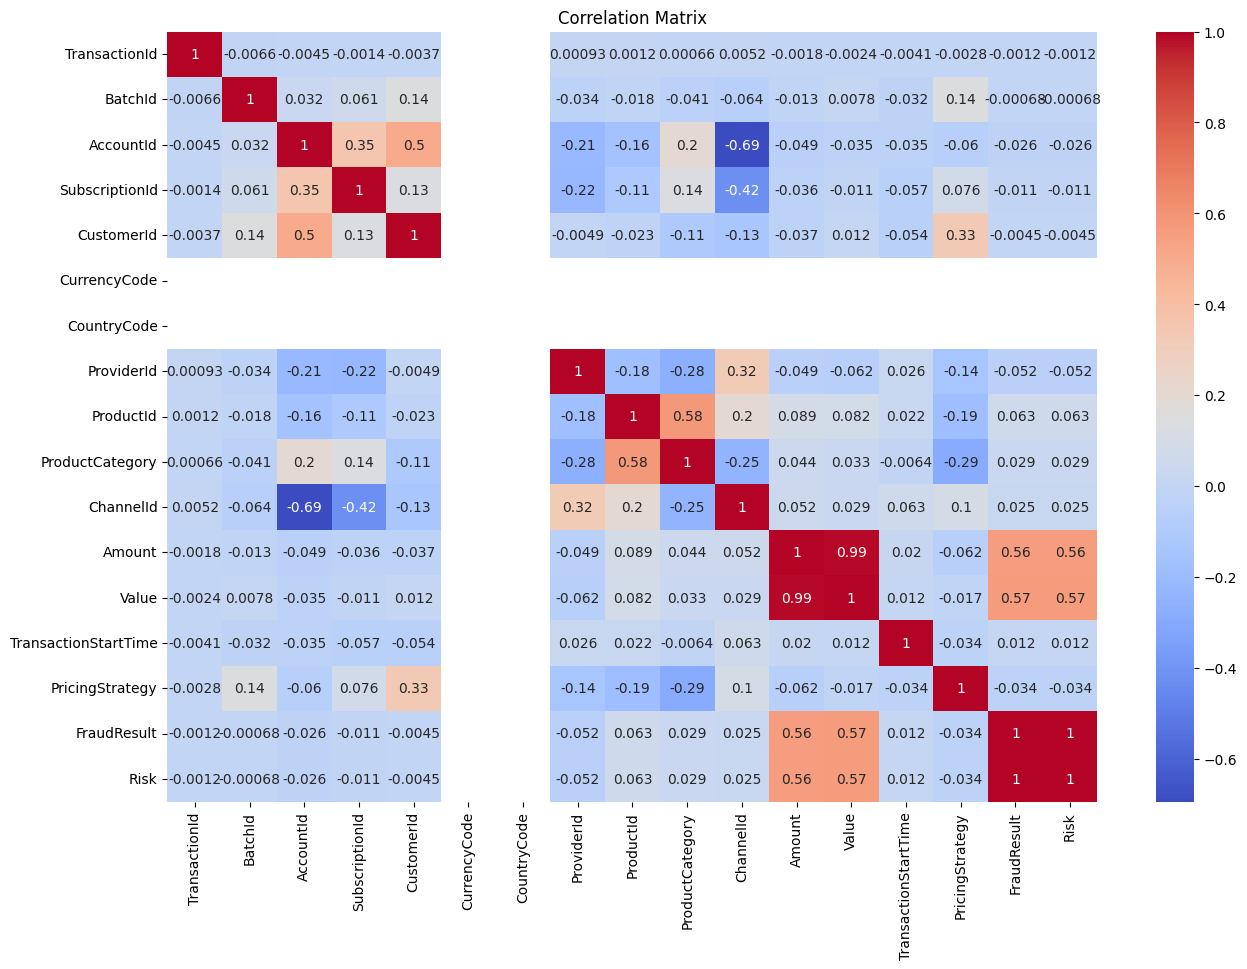

In [21]:
def correlation_analysis(data):
    # Select only numeric columns
    numeric_data = data.select_dtypes(include=np.number)
    
    # Compute correlation matrix
    correlation_matrix = numeric_data.corr()
    
    # Plot heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# Perform correlation analysis
correlation_analysis(data)

In [36]:
# Feature Engineering (based on correlation insights)
# Example: Combine 'Amount' and 'Value' into a single feature
data['TransactionValue'] = data['Amount']  # Assuming 'Amount' is more relevant


In [37]:
# Split data into features (X) and target (y)
X = data.drop('FraudResult', axis=1)
y = data['FraudResult']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Choose models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting Machine': GradientBoostingClassifier()
}

# Train the models
for model_name, model in models.items():
    model.fit(X_train, y_train)


In [43]:

# Hyperparameter Tuning
# Use Grid Search or Random Search to find optimal hyperparameters for each model
# Example using Grid Search for Logistic Regression
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

c:\Users\akili\Desktop\kifiya\week66\BatiBank_creditScoring\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\akili\Desktop\kifiya\week66\BatiBank_creditScoring\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\akili\Desktop\kifiya\week66\BatiBank_creditScoring\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']})

In [44]:
best_log_reg = grid_search.best_estimator_

In [45]:
# Train models (using best parameters for Logistic Regression)
for name, model in models.items():
    if name == 'Logistic Regression':
        model = best_log_reg
    model.fit(X_train, y_train)


In [55]:
# Evaluate the models using the chosen metrics
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f'Model: {model_name}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'F1 Score: {f1_score(y_test, y_pred)}')
    print(f'ROC-AUC: {roc_auc_score(y_test, y_pred)}')
    print('---')

Model: Logistic Regression
Accuracy: 0.9984320284325511
Precision: 0.8
Recall: 0.2222222222222222
F1 Score: 0.34782608695652173
ROC-AUC: 0.6110587468654181
---
Model: Decision Tree
Accuracy: 0.9995296085297654
Precision: 0.8292682926829268
Recall: 0.9444444444444444
F1 Score: 0.8831168831168831
ROC-AUC: 0.9720389473622966
---
Model: Random Forest
Accuracy: 0.9999477342810851
Precision: 1.0
Recall: 0.9722222222222222
F1 Score: 0.9859154929577465
ROC-AUC: 0.9861111111111112
---
Model: Gradient Boosting Machine
Accuracy: 0.9994773428108503
Precision: 0.7954545454545454
Recall: 0.9722222222222222
F1 Score: 0.875
ROC-AUC: 0.9858754720054925
---


In [47]:
# Print best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')


Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.998262096378814


In [48]:
# Retrain the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


LogisticRegression(C=0.1)

In [49]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
print(f'Accuracy (Best Model): {accuracy_score(y_test, y_pred)}')


Accuracy (Best Model): 0.9984320284325511


In [50]:
models

{'Logistic Regression': LogisticRegression(),
 'Decision Tree': DecisionTreeClassifier(),
 'Random Forest': RandomForestClassifier(),
 'Gradient Boosting Machine': GradientBoostingClassifier()}

In [51]:
# Choose the best model based on evaluation metrics (e.g., Random Forest)
best_model = models['Random Forest']

In [52]:
# Predict probabilities (for credit score assignment)
probabilities = best_model.predict_proba(X_test)[:, 1]


In [53]:
# Credit Score Mapping
def risk_to_credit_score(prob):
    return 800 - prob * 700  

credit_scores = np.array([risk_to_credit_score(p) for p in probabilities])
print(credit_scores)

[800. 800. 800. ... 800. 800. 800.]


In [54]:

# Loan Amount and Duration Prediction (Placeholder)
def predict_loan_amount_and_duration(prob):
    if prob < 0.2:
        return 10000, 36
    elif prob < 0.5:
        return 5000, 24
    else:
        return 1000, 12

loan_predictions = np.array([predict_loan_amount_and_duration(p) for p in probabilities])
print(loan_predictions)

[[10000    36]
 [10000    36]
 [10000    36]
 ...
 [10000    36]
 [10000    36]
 [10000    36]]
